In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


In [5]:
from imports.models.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/inceptionv3_unet/new_model.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

Dataset Sample

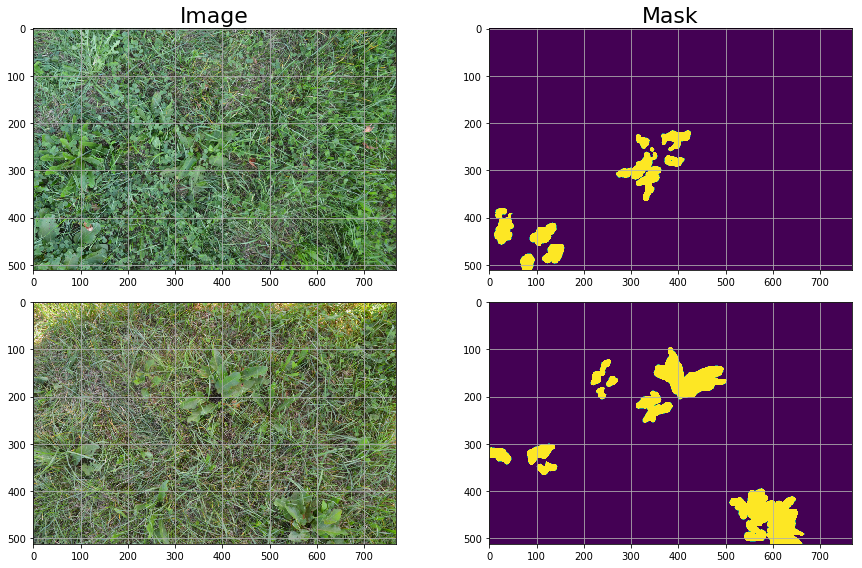

In [6]:
vis_params = {'df':train_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

vis = Visualize(**vis_params)
img1 = vis.get_image('img_1427')
mask1 = vis.get_mask('img_1427')
img2 = vis.get_image('1138')
mask2 = vis.get_mask('1138')

fig = plt.figure(figsize=(13,8))

plt.subplot(221)
plt.imshow(img1)
plt.title('Image'.format(2), fontsize=22)
plt.grid()

plt.subplot(222)
plt.imshow(mask1)
plt.title('Mask'.format(2), fontsize=22)
plt.grid()

plt.subplot(223)
plt.imshow(img2)
plt.grid()

plt.subplot(224)
plt.imshow(mask2)
plt.grid()

fig.tight_layout()

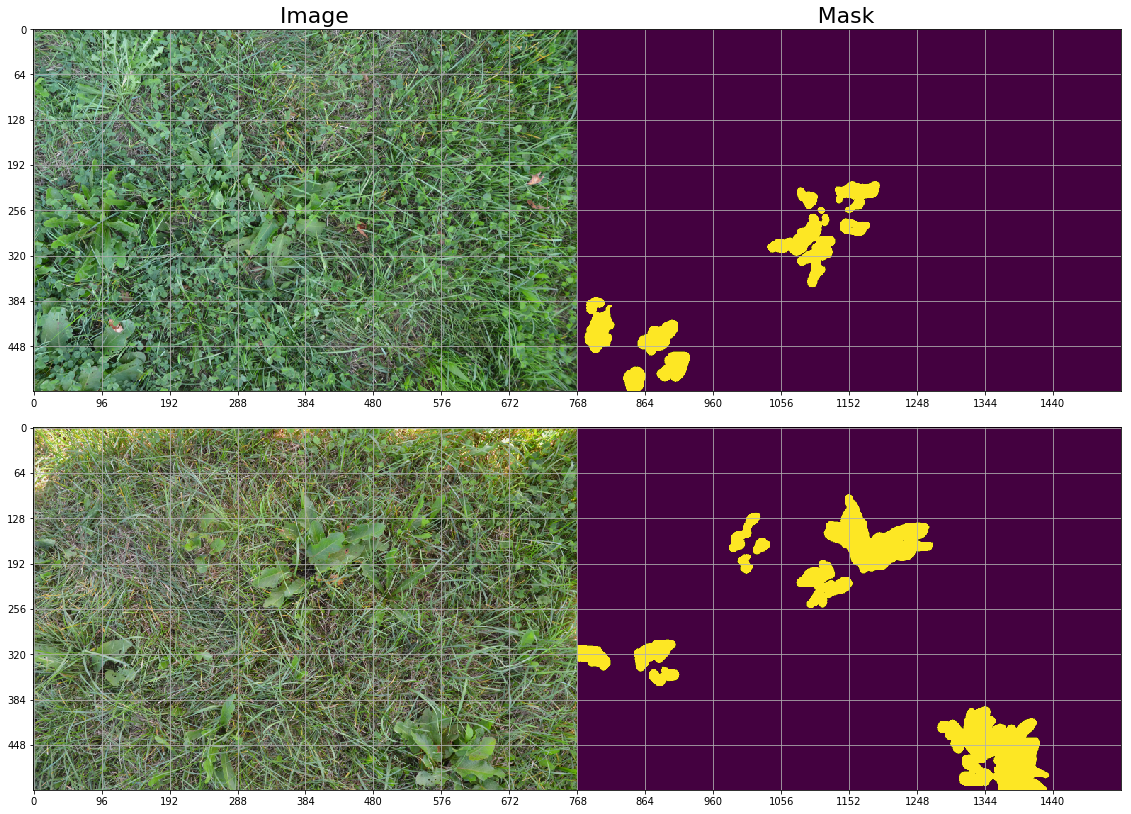

In [7]:
mask1_rgb = np.zeros(img1.shape)
mask1_rgb[:,:,0] = mask1 * (253/255)
mask1_rgb[:,:,1] = mask1 * (231/255)
mask1_rgb[:,:,2] = mask1 * (36/255)

mask1_rgb[:,:,0] = np.where(mask1_rgb[:,:,0]==0, 68/255, mask1_rgb[:,:,0])
mask1_rgb[:,:,1] = np.where(mask1_rgb[:,:,1]==0, 1/255, mask1_rgb[:,:,1]) 
mask1_rgb[:,:,2] = np.where(mask1_rgb[:,:,2]==0, 64/255, mask1_rgb[:,:,2]) 

stack1 = np.hstack((img1,np.ones((512,0,3))))
stack1 = np.hstack((stack1,mask1_rgb))

mask2_rgb = np.zeros(img2.shape)
mask2_rgb[:,:,0] = mask2 * (253/255)
mask2_rgb[:,:,1] = mask2 * (231/255)
mask2_rgb[:,:,2] = mask2 * (36/255)

mask2_rgb[:,:,0] = np.where(mask2_rgb[:,:,0]==0, 68/255, mask2_rgb[:,:,0])
mask2_rgb[:,:,1] = np.where(mask2_rgb[:,:,1]==0, 1/255, mask2_rgb[:,:,1]) 
mask2_rgb[:,:,2] = np.where(mask2_rgb[:,:,2]==0, 64/255, mask2_rgb[:,:,2])

stack2 = np.hstack((img2,np.ones((512,0,3))))
stack2 = np.hstack((stack2,mask2_rgb))

fig = plt.figure(figsize=(20,14))

ax = fig.add_subplot(2, 1, 1)
ax.imshow(stack1)
plt.title('Image                                                                   Mask'.format(2), fontsize=22)

xmajor_ticks = np.arange(0, 1536, 96)
ymajor_ticks = np.arange(0, 512, 64)

ax.set_xticks(xmajor_ticks)
ax.set_yticks(ymajor_ticks)

ax.grid(which='major', alpha=1.0)



ax = fig.add_subplot(2, 1, 2)
ax.imshow(stack2)

xmajor_ticks = np.arange(0, 1536, 96)
ymajor_ticks = np.arange(0, 512, 64)

ax.set_xticks(xmajor_ticks)
ax.set_yticks(ymajor_ticks)

ax.grid(which='major', alpha=1.0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)

In [ ]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

visualize = Visualize(**vis_params)
visualize.show_matrix("random","image_prediction",rows=2)

Prediction Sample

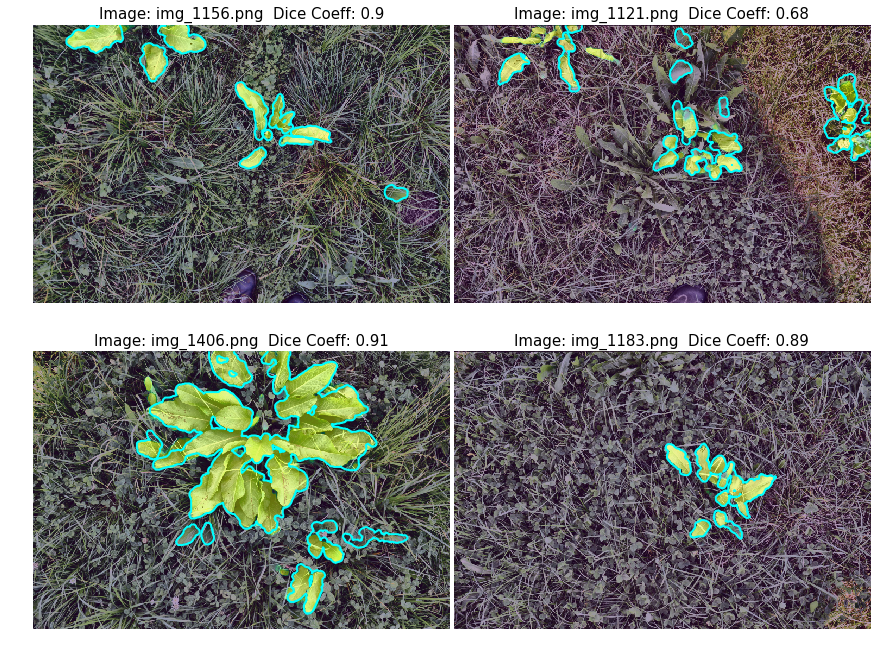

In [26]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

visualize = Visualize(**vis_params)
visualize.show_matrix('random',"image_prediction_contour",rows=2)

Evaluation

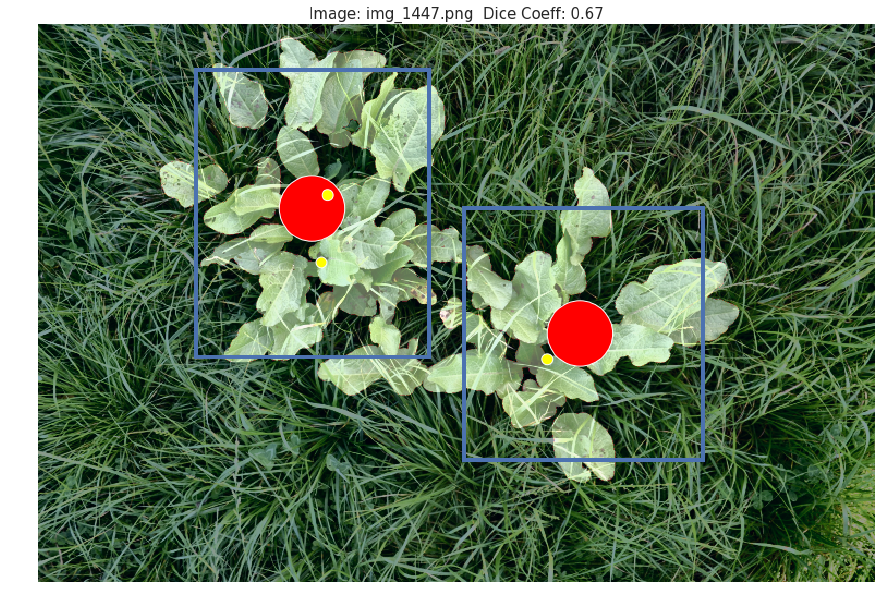

In [112]:
vis_params = {'df':test_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)

#img_1358
visualize.show_single("1447","image_prediction_roots")

In [113]:
tolerance = 30

ev_params = {'df':test_df,
             'input_shape':(512,768,3),
             'pred_layer' : 2,
             'model':model}
ev = Evaluate(**ev_params)

tPs = []
fPs = []
fNs = []
precicions = []
recalls = []
test_log = []
for roots_per_image in range(1,7):
    print("Max roots_per_image: " + str(roots_per_image))
    print("TP\tFP\tFN\tPrecicion\tRecall\tImageName")
    for i,row in test_df.iterrows():
        if len(row["roots"]) <= roots_per_image:
            #print(len(row["roots"]))
            tP, fP, fN, precicion, recall = ev.get_root_precicion_v2(row["name"],tolerance=tolerance,print_distance_matrix=False)
            print("{}\t{}\t{}\t{:1.2f}\t{:1.2f}\t{}".format(tP, fP, fN, precicion, recall, row['name']))
            tPs.append(tP)
            fPs.append(fP)
            fNs.append(fN)
            precicions.append(precicion)
            recalls.append(recall)
    test_log.append((tPs,fPs,fNs,precicions,recalls))
    tPs = []
    fPs = []
    fNs = []
    precicions = []
    recalls = []
    
# axis0 = number ground truth
# axis1 = number predictions

Max roots_per_image: 1
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1030.png
0	1	1	0.00	0.00	img_1032.png
1	0	0	1.00	1.00	img_1044.png
0	1	1	0.00	0.00	img_1143.png
1	0	0	1.00	1.00	img_1205.png
1	0	0	1.00	1.00	img_1217.png
1	0	0	1.00	1.00	img_1219.png
0	1	1	0.00	0.00	img_1232.png
0	2	1	0.00	0.00	img_1277.png
1	0	0	1.00	1.00	img_1304.png
1	1	0	0.50	1.00	img_1361.png
0	1	1	0.00	0.00	img_1390.png
1	0	0	1.00	1.00	img_1392.png
1	0	0	1.00	1.00	img_1393.png
1	1	0	0.50	1.00	img_1432.png
0	1	1	0.00	0.00	img_1434.png
1	0	0	1.00	1.00	img_1466.png
1	0	0	1.00	1.00	img_1498.png
Max roots_per_image: 2
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1030.png
0	1	1	0.00	0.00	img_1032.png
1	0	0	1.00	1.00	img_1044.png
1	1	1	0.50	0.50	img_1062.png
0	1	1	0.00	0.00	img_1143.png
1	1	1	0.50	0.50	img_1154.png
1	0	1	1.00	0.50	img_1164.png
1	0	0	1.00	1.00	img_1205.png
1	0	0	1.00	1.00	img_1217.png
1	0	0	1.00	1.00	img_1219.png
0	1	1	0.00	0.00	img_1232.png
1	1	1	0.50	0.50	img_1262.png
0	2	1	0.00	0

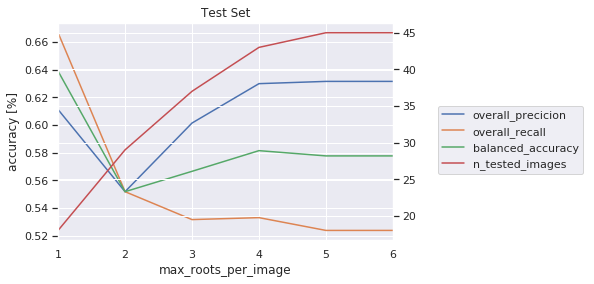

In [114]:
#tolerance 30 v2
results = {"max_roots_per_image":range(1,len(test_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in test_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in test_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in test_log]) + np.asarray([sum(p[4])/len(p[4]) for p in test_log]))/2),
            "n_tested_images":[len(p[0]) for p in test_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="darkgrid")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False, title='Test Set')
ax.set_ylabel("accuracy [%]")
ax2 = ax.twinx()
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

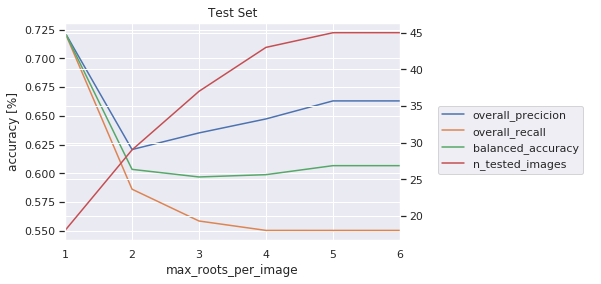

In [96]:
#tolerance 30
results = {"max_roots_per_image":range(1,len(test_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in test_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in test_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in test_log]) + np.asarray([sum(p[4])/len(p[4]) for p in test_log]))/2),
            "n_tested_images":[len(p[0]) for p in test_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="darkgrid")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False, title='Test Set')
ax.set_ylabel("accuracy [%]")
ax2 = ax.twinx()
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

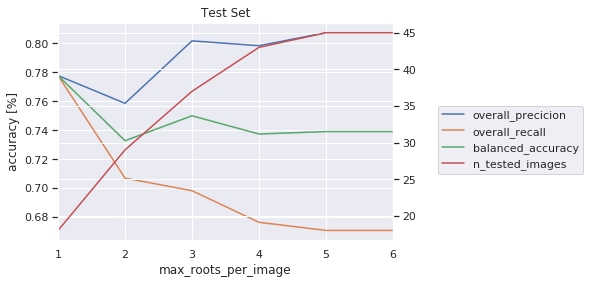

In [94]:
#tolerance 40
results = {"max_roots_per_image":range(1,len(test_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in test_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in test_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in test_log]) + np.asarray([sum(p[4])/len(p[4]) for p in test_log]))/2),
            "n_tested_images":[len(p[0]) for p in test_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="darkgrid")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False, title='Test Set')
ax.set_ylabel("accuracy [%]")
ax2 = ax.twinx()
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Toleranzgrösse

In [5]:
w_img = 149.
b_shoe = 12.3

pairs = [[100,12.3]] # pairs of shows [[width of shoe in mm, length of line in visio in mm]]

tolerance = 30.

print(pairs[0][0]*w_img/pairs[0][1])

pps = 12.3 * (768/149) # pixel per shoe
mm_per_pixel = pairs[0][0]/pps

print("Length of image: " + str(mm_per_pixel*768) + " mm")
print("Diameter of tolerance: " + str(2*tolerance*mm_per_pixel) + " mm")

1211.382113821138
Length of image: 1211.3821138211383 mm
Diameter of tolerance: 94.63922764227644 mm
